In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date > '2011-02-11').all()\
# Calculate the date 1 year ago from the last data point in the database
all_dates = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).all()
all_dates_list = list(np.ravel(all_dates))
max_date = all_dates_list[0]

max_date_year = int(max_date[0:4])
max_date_month = int(max_date[5:7])
max_date_day = int(max_date[8:10])

year_ago_from_max = dt.date(max_date_year, max_date_month, max_date_day) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
year_ago_from_max_data = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date > year_ago_from_max).all()\

# Save the query results as a Pandas DataFrame and set the index to the date column
year_ago_from_max_data = pd.DataFrame(year_ago_from_max_data)
year_ago_from_max_data = year_ago_from_max_data.dropna()
# Sort the dataframe by date
year_ago_from_max_data = year_ago_from_max_data.sort_values("date")


# Use Pandas Plotting with Matplotlib to plot the data


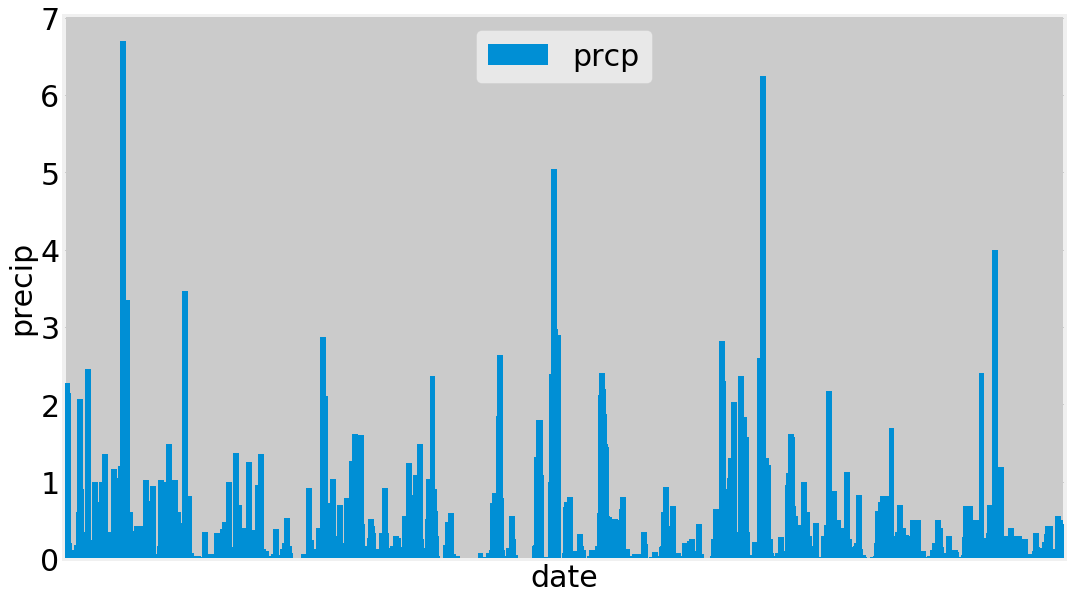

In [69]:
year_ago_from_max_data.plot(kind="bar", width=12, figsize=(16,10))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.yticks(fontsize=30)
plt.legend(loc="upper center", fontsize=30)
plt.xlabel("date", fontsize=30)
plt.ylabel("precip", fontsize=30)
plt.show()



![precipitation](Images/precipitation.png)

In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_ago_from_max_data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [80]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).count()
print(stations)
   
#df = pd.DataFrame(session.query(Measurement.prcp, Measurement.date, Measurement.station).all())
#df["station"].nunique()

9


In [101]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, Measurement.prcp).all()
active_stations = pd.DataFrame(active_stations)
active_stations = active_stations.groupby("station").count().sort_values("prcp", ascending=False)
active_stations = active_stations.rename(columns={"prcp":"count of measurments"})
active_stations

,count of measurments
station,
USC00519281,2772
USC00513117,2696
USC00519397,2685
USC00519523,2572
USC00516128,2484
USC00514830,1937
USC00511918,1932
USC00517948,683
USC00518838,342


In [114]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_temp_at_active_station = session.query(Measurement.station, Measurement.tobs).\
    filter_by(station="USC00519281").all()
low_temp_at_active_station = pd.DataFrame(low_temp_at_active_station)
mintobs = low_temp_at_active_station["tobs"].min()
maxtobs = low_temp_at_active_station["tobs"].max()
avgtobs = low_temp_at_active_station["tobs"].mean()

print(f'The lowest temp at the most active station (USC00519281) is {mintobs}')
print(f'The highest temp at the most active station (USC00519281) is {maxtobs}')
print(f'The average temp at the most active station (USC00519281) is {avgtobs}')

The lowest temp at the most active station (USC00519281) is 54.0
The highest temp at the most active station (USC00519281) is 85.0
The average temp at the most active station (USC00519281) is 71.66378066378067


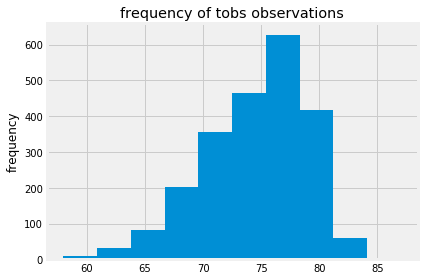

In [147]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
all_dates = session.query(Measurement.date, Measurement.station).\
    filter_by(station="USC00519281").\
    order_by(Measurement.date.desc()).all()
all_dates_list = list(np.ravel(all_dates))
max_date = all_dates_list[0]

max_date_year = int(max_date[0:4])
max_date_month = int(max_date[5:7])
max_date_day = int(max_date[8:10])

year_ago_from_max = dt.date(max_date_year, max_date_month, max_date_day) - dt.timedelta(days=365)

year_ago_from_max_data = session.query(Measurement.tobs).\
    filter(Measurement.date > year_ago_from_max).all()

year_ago_from_max_data = pd.DataFrame(year_ago_from_max_data)
year_ago_from_max_data.hist(bins=10)
plt.ylabel("frequency")
plt.title("frequency of tobs observations")
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [148]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [158]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-03-01', '2017-03-07')

idk = list(np.ravel(trip_temps))
TMIN = idk[0]
TAVE = idk[1]
TMAX = idk[2]

trip_temps

[(62.0, 71.02380952380952, 78.0)]

Text(0, 0.5, 'Degrees')

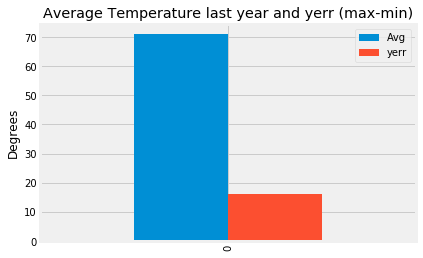

In [177]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yerr = TMAX - TMIN

df = pd.DataFrame([{'Avg': TAVE, 'yerr': yerr}])

df.plot(kind="bar")
plt.title("Average Temperature last year and yerr (max-min)")
plt.ylabel("Degrees")

In [183]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-03-01'
end_date = '2017-03-07'

prcp_by_station = session.query(Measurement.station, Measurement.prcp).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

prcp_by_station = pd.DataFrame(prcp_by_station)
prcp_by_station = prcp_by_station.groupby("station").sum().sort_values("prcp", ascending=False)
prcp_by_station = prcp_by_station.rename(columns={"prcp":"total prcp between start and end date"})
prcp_by_station

station_info = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_info = pd.DataFrame(station_info)
station_info

merge = pd.merge(prcp_by_station, station_info, on="station", how="outer")
merge


,station,total prcp between start and end date,name,latitude,longitude,elevation
0,USC00513117,4.80,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
1,USC00519281,4.71,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00516128,3.49,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,USC00517948,2.98,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00519397,2.74,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,USC00519523,2.32,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00514830,1.12,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
7,USC00518838,NaN,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
8,USC00511918,NaN,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
